In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

: 

In [3]:
bert = pd.read_csv("bert_model_scores.csv")
tfidf = pd.read_csv("tfidf_model_scores.csv")
spacy = pd.read_csv("spacy_model_scores.csv")

In [4]:
fused = tfidf[['job_id', 'decision']].copy()
fused['tfidf_svc'] = tfidf['tfidf_svc_score']
fused['bert_siamese'] = bert['bert_siamese_score'] if 'bert_siamese_score' in bert.columns else bert['tfidf_siamese_score']
fused['spacy_nn'] = spacy['spacy_nn_score']

In [5]:
scaler = MinMaxScaler()
fused[['tfidf_svc', 'bert_siamese', 'spacy_nn']] = scaler.fit_transform(fused[['tfidf_svc', 'bert_siamese', 'spacy_nn']])

In [6]:
X = fused[['tfidf_svc', 'bert_siamese', 'spacy_nn']].values
y = fused['decision'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=fused['job_id'], test_size=0.2, random_state=42)

fusion_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
fusion_model.fit(X_train, y_train)
fused['fusion_score'] = fusion_model.predict_proba(X)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:28:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [7]:
def evaluate_score(name, scores):
    acc = accuracy_score(y, scores >= 0.5)
    auc = roc_auc_score(y, scores)
    return name, acc, auc

results = [
    evaluate_score("TF-IDF LinearSVC", fused['tfidf_svc']),
    evaluate_score("BERT Siamese NN", fused['bert_siamese']),
    evaluate_score("spaCy Keras NN", fused['spacy_nn']),
    evaluate_score("Fusion Model", fused['fusion_score'])
]

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "AUC"])
print("\n📋 Summary Table:")
print(results_df)


📋 Summary Table:
              Model  Accuracy       AUC
0  TF-IDF LinearSVC  0.667633  0.892963
1   BERT Siamese NN  0.819424  0.905586
2    spaCy Keras NN  0.765376  0.860283
3      Fusion Model  0.929385  0.963544


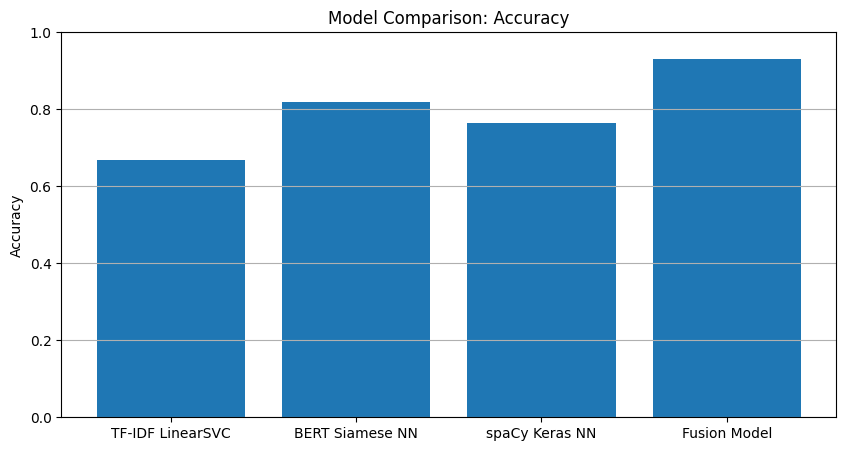

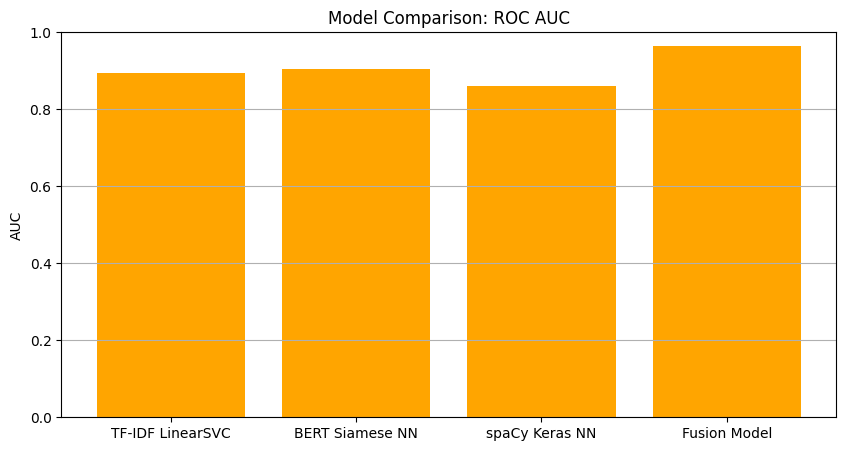

In [8]:
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['Accuracy'], label='Accuracy')
plt.title("Model Comparison: Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['AUC'], label='AUC', color='orange')
plt.title("Model Comparison: ROC AUC")
plt.ylabel("AUC")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

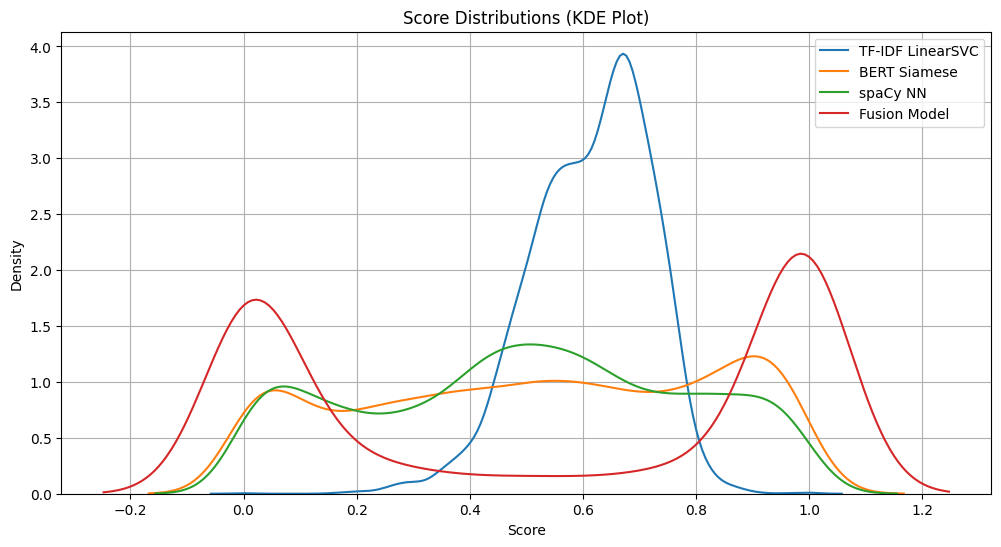

In [9]:
plt.figure(figsize=(12, 6))
sns.kdeplot(fused['tfidf_svc'], label='TF-IDF LinearSVC')
sns.kdeplot(fused['bert_siamese'], label='BERT Siamese')
sns.kdeplot(fused['spacy_nn'], label='spaCy NN')
sns.kdeplot(fused['fusion_score'], label='Fusion Model')
plt.title("Score Distributions (KDE Plot)")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
fused.to_csv("fusion_model_scores.csv", index=False)

In [21]:
def get_ranked_cvs(job_id, top_n=10):
    subset = fused[fused['job_id'] == job_id].copy()
    subset['cv_index'] = subset.index
    ranked = subset.sort_values(by='fusion_score', ascending=False).reset_index(drop=True)
    ranked['Rank'] = ranked.index + 1
    return ranked[['cv_index','Rank', 'fusion_score', 'decision']].head(top_n)

# Example usage:
print(get_ranked_cvs(job_id=0,top_n=60))

    cv_index  Rank  fusion_score  decision
0         45     1      0.999901         1
1         40     2      0.999673         1
2         33     3      0.999644         1
3         46     4      0.999494         1
4         41     5      0.998572         1
5         38     6      0.997536         1
6         47     7      0.997405         1
7         39     8      0.997236         1
8         43     9      0.994366         1
9         32    10      0.992604         1
10        49    11      0.986644         1
11        31    12      0.979362         1
12        36    13      0.970583         1
13        35    14      0.965917         1
14        30    15      0.963252         1
15        48    16      0.951627         1
16        44    17      0.921348         1
17        34    18      0.919266         1
18        37    19      0.917601         1
19        42    20      0.916881         1
20        29    21      0.916232         1
21        10    22      0.897141         0
22         